In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:
train_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/train'
val_dir = '/kaggle/input/fruit-and-vegetable-image-recognition/validation'
test_dir ='/kaggle/input/fruit-and-vegetable-image-recognition/test'

In [3]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 36
Класи: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Розмір тренувального набору: 3115
Розмір валідаційного набору: 351
Розмір тестового набору: 359

Розподіл класів у тренувальному наборі:
apple: 68
banana: 75
beetroot: 88
bell pepper: 90
cabbage: 92
capsicum: 89
carrot: 82
cauliflower: 79
chilli pepper: 87
corn: 87
cucumber: 94
eggplant: 84
garlic: 92
ginger: 68
grapes: 100
jalepeno: 88
kiwi: 88
lemon: 82
lettuce: 97
mango: 86
onion: 94
orange: 69
paprika: 83
pear: 89
peas: 100
pineapple: 99
pomegranate: 79
potato: 77
raddish: 81
soy beans: 97
spinach: 97
sweetcorn: 91
sweetpotato: 69
tomato: 92
turnip: 98
water

In [7]:
model = models.vgg16(pretrained=True)

# Заморожування параметрів моделі
for param in model.parameters():
    param.requires_grad = False

# Заміна останнього повнозв'язного шару
num_ftrs = model.classifier[6].in_features  # Останній шар у classifier
model.classifier[6] = nn.Linear(num_ftrs, 36)  # 36 класів у наборі даних

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

num_epochs = 10
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [9]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_2.pth')

100%|██████████| 98/98 [02:31<00:00,  1.55s/it]


Epoch 1/10:
Train Loss: 1.4709, Train Accuracy: 0.5884
Val Loss: 0.3994, Val Accuracy: 0.8946


100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


Epoch 2/10:
Train Loss: 0.7527, Train Accuracy: 0.7602
Val Loss: 0.3157, Val Accuracy: 0.9145


100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


Epoch 3/10:
Train Loss: 0.5760, Train Accuracy: 0.8167
Val Loss: 0.2400, Val Accuracy: 0.9288


100%|██████████| 98/98 [01:55<00:00,  1.18s/it]


Epoch 4/10:
Train Loss: 0.5054, Train Accuracy: 0.8321
Val Loss: 0.2319, Val Accuracy: 0.9288


100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


Epoch 5/10:
Train Loss: 0.4419, Train Accuracy: 0.8539
Val Loss: 0.2583, Val Accuracy: 0.9259


100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


Epoch 6/10:
Train Loss: 0.4121, Train Accuracy: 0.8626
Val Loss: 0.2251, Val Accuracy: 0.9202


100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


Epoch 7/10:
Train Loss: 0.3692, Train Accuracy: 0.8835
Val Loss: 0.1995, Val Accuracy: 0.9402


100%|██████████| 98/98 [01:55<00:00,  1.17s/it]


Epoch 8/10:
Train Loss: 0.3584, Train Accuracy: 0.8899
Val Loss: 0.1914, Val Accuracy: 0.9487


100%|██████████| 98/98 [01:52<00:00,  1.14s/it]


Epoch 9/10:
Train Loss: 0.3173, Train Accuracy: 0.8931
Val Loss: 0.1951, Val Accuracy: 0.9345


100%|██████████| 98/98 [01:54<00:00,  1.17s/it]


Epoch 10/10:
Train Loss: 0.3169, Train Accuracy: 0.8989
Val Loss: 0.1801, Val Accuracy: 0.9544


In [10]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [11]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
model.load_state_dict(torch.load('best_model_2.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.9526
F1 Score: 0.9521


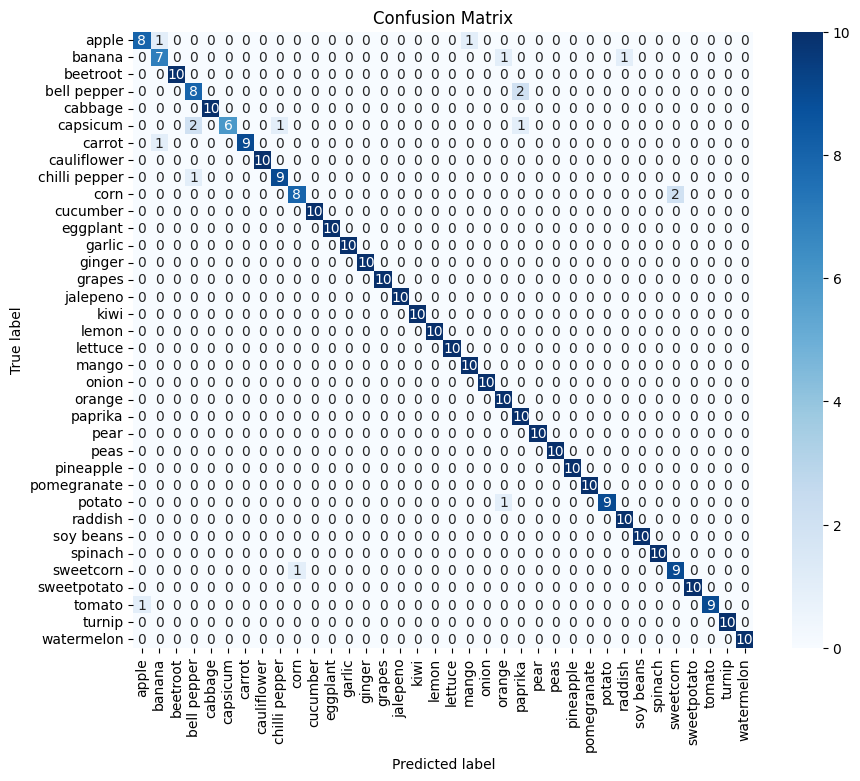

In [13]:
class_names = train_dataset.classes  

# Обчислення точності та F1 
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

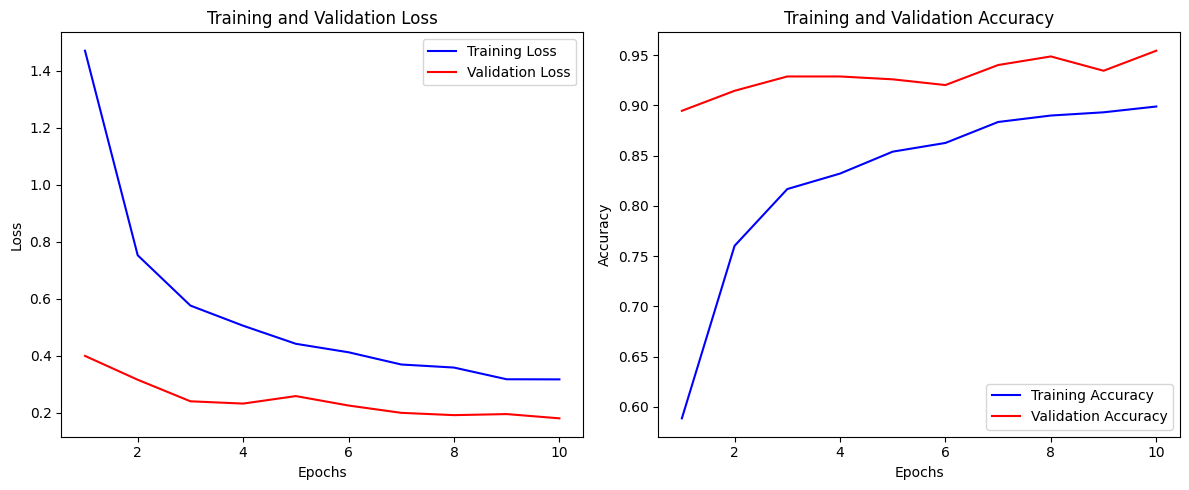

In [14]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

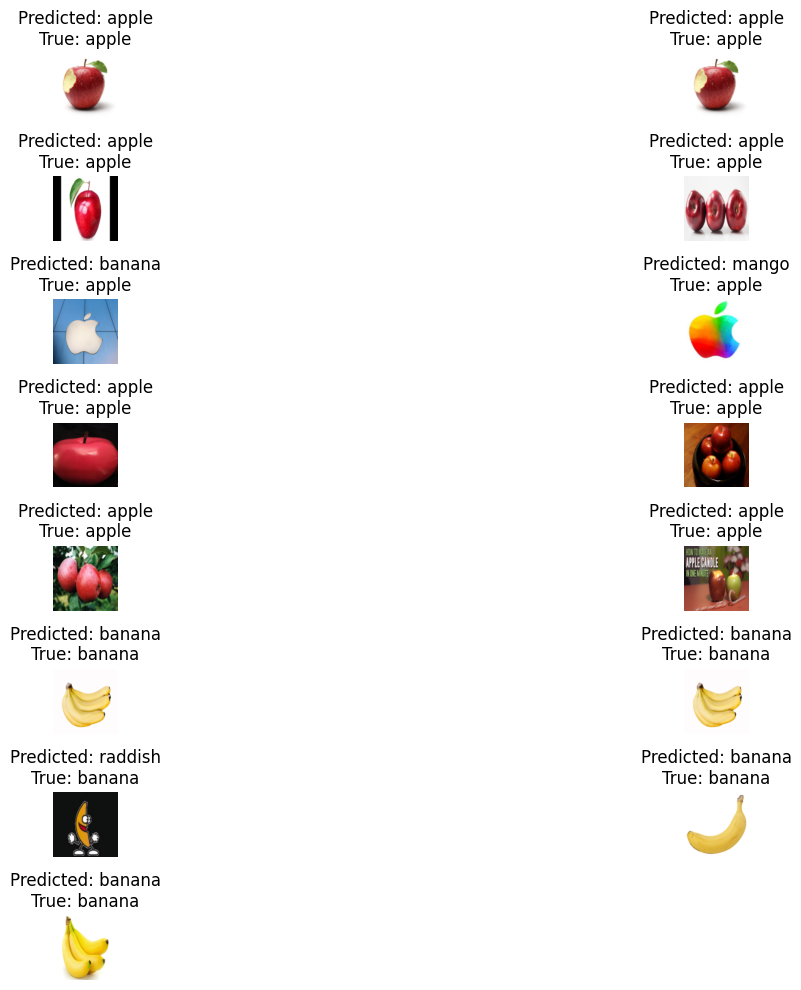

In [15]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)